Test for additional features from others sources to increase total data available

In [2]:
#list of imports

#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#specific imports
from xgboost import XGBRegressor

#Sklearn
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.compose    import make_column_transformer, make_column_selector

from sklearn.metrics    import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression

In [79]:
import yfinance as yf

start_date = '1980-01-01'
end_date = '2025-12-01'
interval = '1d'

df_yahoo = yf.download('GC=F', start=start_date, end=end_date, interval=interval)
gold_yahoo = pd.DataFrame(df_yahoo)
gold_yahoo = gold_yahoo.reset_index()
gold_yahoo.columns = gold_yahoo.columns.droplevel(1)
df_yahoo.to_csv('gold_price_5y_1h.csv')


/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/1484050136.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yahoo = yf.download('GC=F', start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


In [37]:
gold_yahoo.tail(10)

Price,Date,Close,High,Low,Open,Volume
6326,2025-11-14,4087.600098,4197.899902,4047.000000,4197.700195,483
6327,2025-11-17,4068.300049,4099.500000,4019.399902,4070.000000,1552
6328,2025-11-18,4061.300049,4063.399902,4035.600098,4037.399902,1375
6329,2025-11-19,4077.699951,4122.700195,4072.000000,4086.100098,486
6330,2025-11-20,4056.500000,4090.399902,4040.199951,4045.000000,202
6331,2025-11-21,4076.699951,4085.199951,4031.800049,4031.800049,171
6332,2025-11-24,4091.899902,4091.899902,4060.500000,4060.500000,591
6333,2025-11-25,4139.200195,4139.200195,4139.200195,4139.200195,132704
6334,2025-11-26,4165.200195,4171.000000,4127.500000,4128.600098,25088
6335,2025-11-28,4218.299805,4223.899902,4140.000000,4163.399902,3615


In [38]:
gold_yahoo.shape

(6336, 6)

<Axes: >

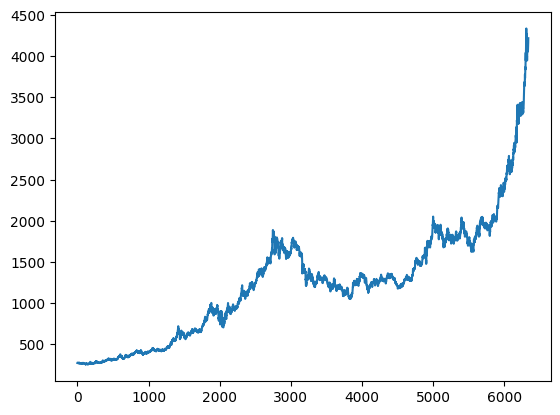

In [39]:
gold_yahoo['Close'].plot()

In [ ]:
#Features and target(push 1 day ahead for target)
X = gold_yahoo.drop(columns=['Close'])
X = X[1:]
y = gold_yahoo['Close'].shift(1).dropna()

X.shape, y.shape

((6335, 5), (6335,))

In [41]:
X.dtypes

Price
Date      datetime64[ns]
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [42]:
y.dtypes

dtype('float64')

In [43]:
#preprocessing

preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    RobustScaler()
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, [ 'High', 'Low', 'Open', 'Volume']),
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['High', 'Low', 'Open', 'Volume'])])

In [44]:
# Create eval test just for early-stopping purposes
train_size = int(0.8 * len(X))
X_train, X_eval = X[:train_size], X[train_size:]
y_train, y_eval = y[:train_size], y[train_size:]

In [51]:
X_train.tail(10)

Price,Date,High,Low,Open,Volume
5059,2020-11-02,1894.699951,1872.900024,1872.900024,190
5060,2020-11-03,1908.500000,1891.500000,1891.500000,712
5061,2020-11-04,1907.000000,1885.300049,1893.800049,782
5062,2020-11-05,1948.000000,1901.699951,1901.699951,135
5063,2020-11-06,1958.800049,1940.800049,1940.800049,304
5064,2020-11-09,1963.199951,1847.099976,1955.599976,745
5065,2020-11-10,1885.300049,1871.199951,1879.300049,276
5066,2020-11-11,1878.800049,1855.500000,1878.800049,222
5067,2020-11-12,1878.500000,1866.599976,1869.000000,220
5068,2020-11-13,1890.099976,1876.800049,1877.000000,240


In [52]:
print(X_train.columns)

Index(['Date', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [53]:
# Preprocess eval data
preproc_baseline.fit(X_train, y_train)
X_train_preproc = preproc_baseline.transform(X_train)
X_eval_preproc = preproc_baseline.transform(X_eval)

In [54]:
# Create a linear regression model
model_lr = LinearRegression()

# Train the model
model_lr.fit(X_train_preproc, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_eval_preproc)

# Calculate MAE
mae_lr = mean_absolute_error(y_eval, y_pred_lr)
print(f"MAE (Linear Regression): {mae_lr:.2f}")

MAE (Linear Regression): 7.94


In [55]:
# SARIMAX test

import pmdarima as pm
sarimax = pm.auto_arima(y_train, exogenous=X_train_preproc,
                           start_p=1, start_d=1,start_q=1,
                           test='adf',
                           max_p=3, max_d=2, max_q=3, m=1,
                           start_P=0, seasonal=True,
                           D=None, trace=True,
                           suppress_warnings=True,
                           stepwise=False, n_jobs=-1,
                           random=True, random_state=42)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=39931.180, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=39932.128, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=39932.130, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=39934.124, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=39934.124, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=39934.125, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=39938.123, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=39936.128, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=39940.122, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=39940.119, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[1] intercept
Total fit time: 2.312 seconds


In [56]:
# Prediction
y_pred_sar = sarimax.predict(n_periods=len(y_eval), exogenous=X_eval_preproc)

# Calculate MAE

mae_sarimax = mean_absolute_error(y_eval, y_pred_sar)

print(f"MAE: {mae_sarimax:.2f}")

MAE: 349.04


/Users/rafael.hayashi/.pyenv/versions/3.10.6/envs/forecasting_gold_price/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/rafael.hayashi/.pyenv/versions/3.10.6/envs/forecasting_gold_price/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [71]:
# S&P500 - 500 biggest companies USA

df_SP500 = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)
SP500_yahoo = pd.DataFrame(df_SP500)
SP500_yahoo = SP500_yahoo.reset_index()
SP500_yahoo.columns = SP500_yahoo.columns.droplevel(1)

SP500_yahoo

/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/2231353976.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_SP500 = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,1980-01-02,105.760002,108.430000,105.290001,107.940002,40610000
1,1980-01-03,105.220001,106.080002,103.260002,105.760002,50480000
2,1980-01-04,106.519997,107.080002,105.089996,105.220001,39130000
3,1980-01-07,106.809998,107.800003,105.800003,106.519997,44500000
4,1980-01-08,108.949997,109.290001,106.290001,106.809998,53390000
...,...,...,...,...,...,...
11568,2025-11-21,6602.990234,6660.049805,6521.919922,6555.770020,5929930000
11569,2025-11-24,6705.120117,6715.750000,6630.700195,6636.540039,6039740000
11570,2025-11-25,6765.879883,6776.399902,6659.979980,6697.029785,5003330000
11571,2025-11-26,6812.609863,6831.439941,6783.870117,6793.549805,4485000000


In [70]:
# US BONDS

df_bonds = yf.download('BOND', start=start_date, end=end_date, interval=interval)
bonds_yahoo = pd.DataFrame(df_bonds)
bonds_yahoo = bonds_yahoo.reset_index()
bonds_yahoo.columns = bonds_yahoo.columns.droplevel(1)

bonds_yahoo

/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/197946414.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_bonds = yf.download('BOND', start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2012-03-01,61.905231,61.991933,61.886653,61.991933,550900
1,2012-03-02,62.121967,62.208669,62.041460,62.202479,331600
2,2012-03-05,62.115776,62.258212,62.103387,62.258212,237800
3,2012-03-06,62.394447,62.450182,62.245817,62.394447,176500
4,2012-03-07,62.481186,62.536925,62.481186,62.487380,182600
...,...,...,...,...,...,...
3453,2025-11-21,93.261322,93.340976,93.111959,93.340976,444300
3454,2025-11-24,93.460472,93.480384,93.321069,93.370851,294200
3455,2025-11-25,93.669579,93.779111,93.500304,93.550087,295900
3456,2025-11-26,93.749237,93.769149,93.480382,93.659616,371300


In [69]:
# BITCOIN

df_btc = yf.download('BTC-USD', start=start_date, end=end_date, interval=interval)
btc_yahoo = pd.DataFrame(df_btc)
btc_yahoo = btc_yahoo.reset_index()
btc_yahoo.columns = btc_yahoo.columns.droplevel(1)


btc_yahoo

/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/3305658997.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_btc = yf.download('BTC-USD', start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...,...
4088,2025-11-26,90518.367188,90581.156250,86316.898438,87345.585938,66496301869
4089,2025-11-27,91285.375000,91897.578125,90089.515625,90517.765625,57040622845
4090,2025-11-28,90919.265625,92969.085938,90257.117188,91285.382812,60895830289
4091,2025-11-29,90851.757812,91187.617188,90260.187500,90918.742188,37921773455


In [68]:
# Gold miners ETF

df_gdx = yf.download('GDX', start=start_date, end=end_date, interval=interval)
gdx_yahoo = pd.DataFrame(df_gdx)
gdx_yahoo = gdx_yahoo.reset_index()
gdx_yahoo.columns = gdx_yahoo.columns.droplevel(1)

btc_yahoo

/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/1920129867.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_gdx = yf.download('GDX', start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...,...
4088,2025-11-26,90518.367188,90581.156250,86316.898438,87345.585938,66496301869
4089,2025-11-27,91285.375000,91897.578125,90089.515625,90517.765625,57040622845
4090,2025-11-28,90919.265625,92969.085938,90257.117188,91285.382812,60895830289
4091,2025-11-29,90851.757812,91187.617188,90260.187500,90918.742188,37921773455


In [67]:
# Crude Oil

df_clf = yf.download('CL=F', start=start_date, end=end_date, interval=interval)
clf_yahoo = pd.DataFrame(df_clf)
clf_yahoo = clf_yahoo.reset_index()
clf_yahoo.columns = clf_yahoo.columns.droplevel(1)

clf_yahoo

/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/4171235434.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_clf = yf.download('CL=F', start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2000-08-23,32.049999,32.799999,31.950001,31.950001,79385
1,2000-08-24,31.629999,32.240002,31.400000,31.900000,72978
2,2000-08-25,32.049999,32.099998,31.320000,31.700001,44601
3,2000-08-28,32.869999,32.919998,31.860001,32.040001,46770
4,2000-08-29,32.720001,33.029999,32.560001,32.820000,49131
...,...,...,...,...,...,...
6340,2025-11-21,58.060001,58.799999,57.380001,58.799999,345014
6341,2025-11-24,58.840000,59.060001,57.419998,58.049999,238138
6342,2025-11-25,57.950001,58.959999,57.099998,58.889999,334442
6343,2025-11-26,58.650002,58.720001,57.660000,58.049999,228285


In [73]:
# Euro STOXX 600 - 600 companies europe

df_stoxx = yf.download('^STOXX', start=start_date, end=end_date, interval=interval)
stoxx_yahoo = pd.DataFrame(df_stoxx)
stoxx_yahoo = stoxx_yahoo.reset_index()
stoxx_yahoo.columns = stoxx_yahoo.columns.droplevel(1)

stoxx_yahoo

/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/909206226.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_stoxx = yf.download('^STOXX', start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2004-04-26,247.070007,248.149994,246.899994,246.949997,0
1,2004-04-27,246.919998,247.660004,246.229996,247.190002,0
2,2004-04-28,243.380005,247.050003,243.380005,246.960007,0
3,2004-04-29,241.250000,243.429993,240.169998,243.190002,0
4,2004-04-30,239.050003,240.809998,239.050003,240.809998,0
...,...,...,...,...,...,...
5429,2025-11-24,562.880005,566.109985,560.969971,563.200012,366791700
5430,2025-11-25,568.010010,568.219971,561.780029,563.460022,176713700
5431,2025-11-26,574.210022,574.369995,568.390015,569.260010,208067900
5432,2025-11-27,575.000000,575.390015,572.969971,574.219971,148173600


In [74]:
# JP Morgan - bank with sigficant gold reserve

df_jpm = yf.download('JPM', start=start_date, end=end_date, interval=interval)
jpm_yahoo = pd.DataFrame(df_jpm)
jpm_yahoo = jpm_yahoo.reset_index()
jpm_yahoo.columns = jpm_yahoo.columns.droplevel(1)

jpm_yahoo

/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/1410211759.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_jpm = yf.download('JPM', start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,1980-03-17,1.042893,1.062064,1.039059,1.039059,62775
1,1980-03-18,1.050561,1.058230,1.042893,1.042893,64125
2,1980-03-19,1.065898,1.069732,1.058230,1.058230,40500
3,1980-03-20,1.058230,1.065899,1.054396,1.065899,18900
4,1980-03-21,1.081235,1.081235,1.058230,1.058230,97200
...,...,...,...,...,...,...
11516,2025-11-21,298.019989,301.679993,292.809998,301.290009,11766800
11517,2025-11-24,298.000000,299.820007,294.510010,298.239990,10940200
11518,2025-11-25,303.000000,304.500000,295.559998,300.049988,8877200
11519,2025-11-26,307.640015,308.529999,303.200012,305.000000,7910900


In [76]:
# Commodity Index - ETF future commodity market

df_gdf = yf.download('GD=F', start=start_date, end=end_date, interval=interval)
gdf_yahoo = pd.DataFrame(df_gdf)
gdf_yahoo = gdf_yahoo.reset_index()
gdf_yahoo.columns = gdf_yahoo.columns.droplevel(1)

gdf_yahoo.columns = ['Date'] + [f'gdf_{col}' for col in gdf_yahoo.columns[1:]]

gdf_yahoo

/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/3141414091.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_gdf = yf.download('GD=F', start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed


,Date,gdf_Close,gdf_High,gdf_Low,gdf_Open,gdf_Volume
0,2006-03-15,436.000000,436.000000,436.000000,436.000000,0
1,2006-03-16,440.000000,440.000000,440.000000,440.000000,0
2,2006-03-17,440.000000,440.000000,440.000000,440.000000,0
3,2006-03-20,427.500000,427.500000,427.500000,427.500000,0
4,2006-03-21,431.750000,431.750000,431.750000,431.750000,0
...,...,...,...,...,...,...
4950,2025-11-21,546.450012,546.900024,542.450012,546.900024,55
4951,2025-11-24,547.400024,548.049988,541.450012,544.799988,170
4952,2025-11-25,541.700012,543.250000,539.599976,539.599976,2
4953,2025-11-26,549.450012,549.450012,549.400024,549.400024,2


In [84]:
def download_and_concat_tickers(tickers, start_date, end_date, interval):
    dataframes = []
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
        df = pd.DataFrame(df)
        df = df.reset_index()
        df.columns = df.columns.droplevel(1)
        df.columns = ['Date'] + [f'{ticker}_{col}' for col in df.columns[1:]]
        dataframes.append(df)

    concatenated_df = dataframes[0]
    for df in dataframes[1:]:
        concatenated_df = pd.merge(concatenated_df, df, on='Date', how='outer')
    return concatenated_df

# Example usage:
tickers = ['GC=F', '^GSPC', 'BOND', 'BTC-USD','GDX','CL=F','^STOXX','JPM','GD=F','^DJI', '^VIX', 'GVZ','^OVX', '^MOVE','EURUSD=X', 'DX-Y.NYB', 'BZ=F', 'SI=F', 'PL=F','PA=F', '^TNX', 'GC=F','EGO','USO']


result_df = download_and_concat_tickers(tickers, start_date, end_date, interval)


/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/917750804.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/917750804.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/917750804.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/917750804.py:4: F

[*********************100%***********************]  1 of 1 completed
/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/917750804.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/917750804.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GVZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 1980-01-01 -> 2025-12-01)')
/var/folders/cv/0c80h97d4ksflxwnpnhp9g2m0000gn/T/ipykernel_86438/917750804.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=star

In [89]:
result_df.shape

(13087, 122)

In [90]:
result_df.to_csv('gold-exo-2000-2025-1d.csv')